In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
data = pd.read_csv('./diabetes.csv') # 匯入datasets

## 分析與評估資料

### 1.觀察數據集，了解各變數所代表意義

    Pregnancies → 懷孕次數
    Glucose → 血糖
    BloodPressure → 血壓
    skinTinckness → 皮膚厚度
    Insulin → 胰島素濃度
    BMI 
    DiabetesPedigreeFunction → 糖尿病函數(個人得糖尿病的風險值)
    Age → 年齡
    outcome → 是否患有疾病(0代表無糖尿病，1代表患有糖尿病)

In [3]:
pd.set_option("display.max_row", None) #使此 dataframe 在 jupyter notebook 中，可以完整顯示整行的數值
pd.set_option("display.width", 1000) #使此 dataframe 在 jupyter notebook 中輸出不換行
print(data)

     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  DiabetesPedigreeFunction  Age  Outcome
0              6      148             72             35        0  33.6                     0.627   50        1
1              1       85             66             29        0  26.6                     0.351   31        0
2              8      183             64              0        0  23.3                     0.672   32        1
3              1       89             66             23       94  28.1                     0.167   21        0
4              0      137             40             35      168  43.1                     2.288   33        1
5              5      116             74              0        0  25.6                     0.201   30        0
6              3       78             50             32       88  31.0                     0.248   26        1
7             10      115              0              0        0  35.3                     0.134   29        0
8

In [4]:
data.dtypes #檢查數據類型，所有特徵都為數值型資料型態

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

### 2.數值特徵分佈

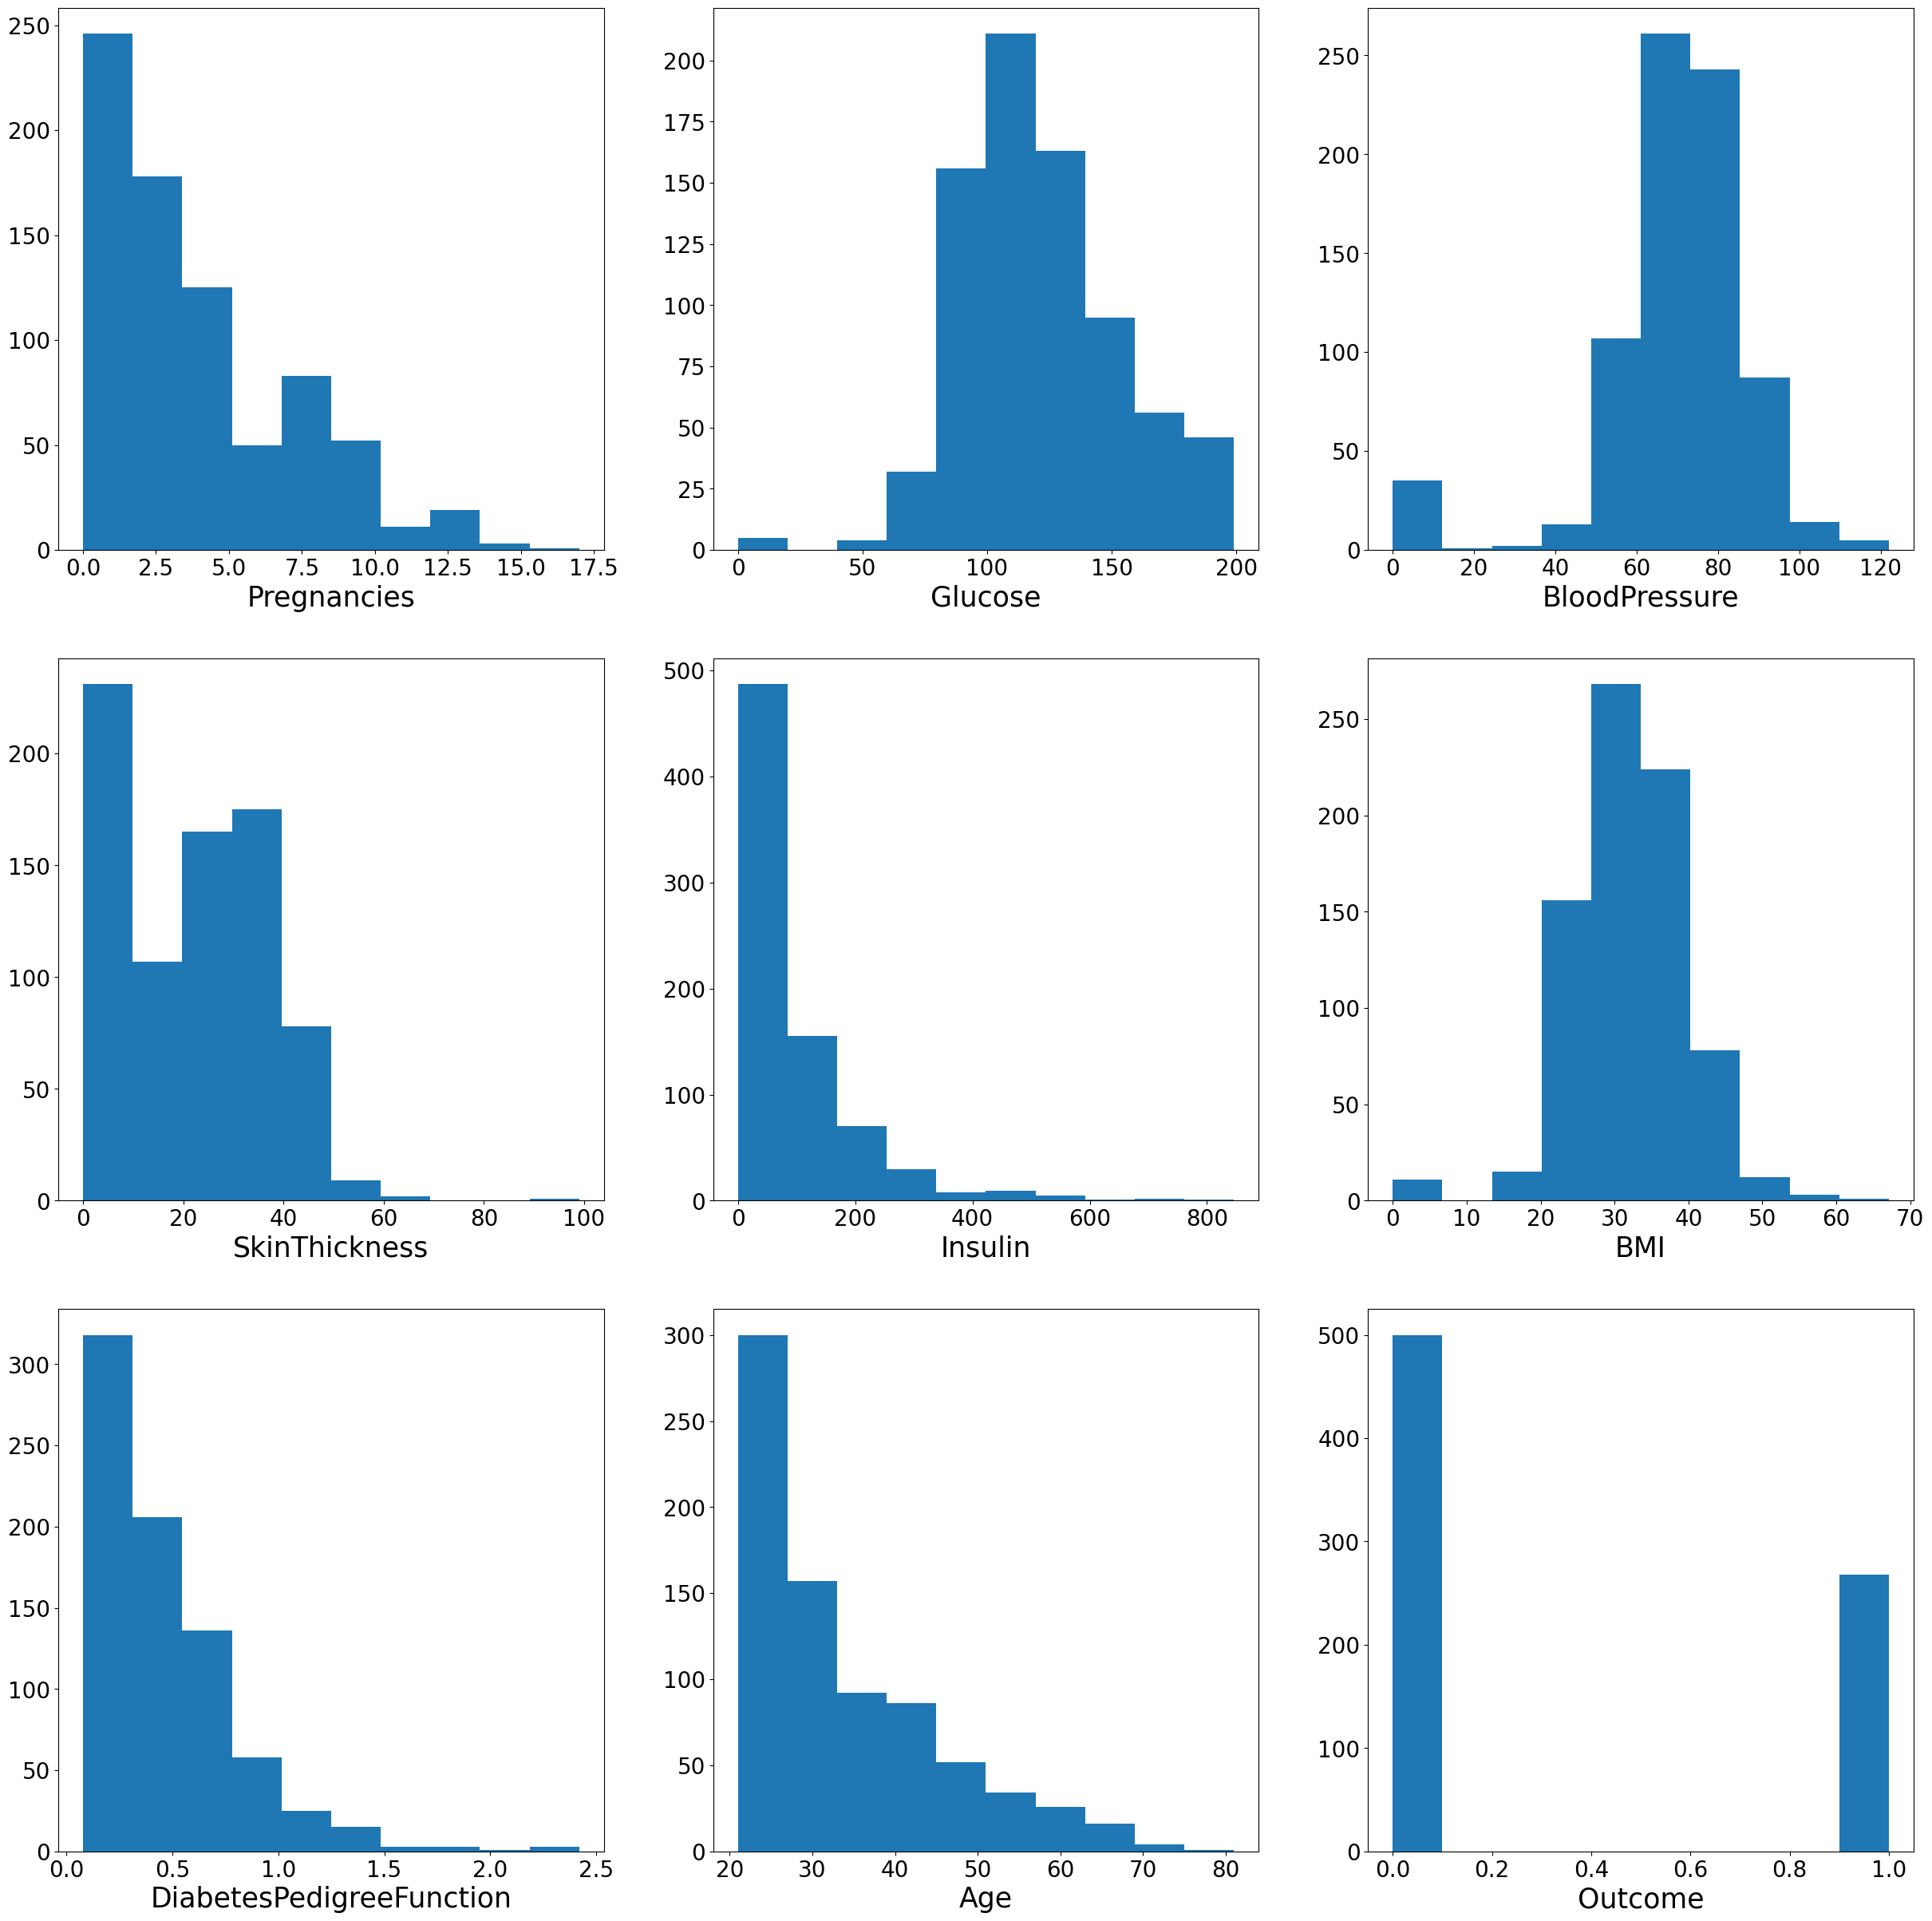

In [5]:
columns = [_ for _ in data.columns]
plt.figure(figsize=(30, 30))
parameters = {'xtick.labelsize': 20, 'ytick.labelsize': 20, 'axes.labelsize':25} #設定 x 和 y 標籤及座標刻度字型大小
plt.rcParams.update(parameters)

for index, column in enumerate(columns):
    plt.subplot(3, 3, index+1)
    plt.hist(data[column])
    plt.xlabel(column)
    
plt.show()

### 由長條圖觀察數值特徵
    在所有變數當中，Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI 由圖皆可觀察出具有值為 0 的現象。
    但根據常識判斷可發現有些數值是有問題的
        pregnancies = 0    → 懷孕次數 0     → 合理
        Glucose = 0        → 血糖濃度 0     → 不合理 
        BloodPressure = 0  → 血壓 0         → 不合理
        SkinThickness = 0  → 皮膚厚度 0     → 不合理
        Insulin = 0        → 胰島素濃度 0   → 不合理
        (Google搜尋結果，胰島素為 0 的情況確實有機會發生，但機會極小，然而本數據中有太多胰島素為 0，因此判斷此變數值 0 也屬於不合理)
        BMI = 0                            → 不合理

### 3.處理缺失值

In [6]:
change_list = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI'] #具有異常值的欄位
data.loc[:, change_list] = data.loc[:, change_list].replace(0, np.nan) #先將不合理的變數值 0 轉換為缺失值 Nan
pd.set_option("display.max_row", None)
pd.set_option("display.width", 1000)
print(data)

     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  DiabetesPedigreeFunction  Age  Outcome
0              6    148.0           72.0           35.0      NaN  33.6                     0.627   50        1
1              1     85.0           66.0           29.0      NaN  26.6                     0.351   31        0
2              8    183.0           64.0            NaN      NaN  23.3                     0.672   32        1
3              1     89.0           66.0           23.0     94.0  28.1                     0.167   21        0
4              0    137.0           40.0           35.0    168.0  43.1                     2.288   33        1
5              5    116.0           74.0            NaN      NaN  25.6                     0.201   30        0
6              3     78.0           50.0           32.0     88.0  31.0                     0.248   26        1
7             10    115.0            NaN            NaN      NaN  35.3                     0.134   29        0
8

### 移除缺失值
    由長條圖中發現，SkinThickness 以及 Insulin 的缺失值特別多，若是採用直接刪除具有缺失值之整列資料的方式，可能會刪除過多樣本，導致分析結果可信度降低。因此，在這裡選擇使用隨機森林演算法，對這兩個變量的缺失值進行填補。

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer  

In [8]:
class MissingValueFiller:
    def __init__(self, strategy='median'):
        self.strategy = strategy
        self.imputer = SimpleImputer(strategy=self.strategy)
        self.model = RandomForestRegressor()

    def fill(self, data, feature):

        copy_data = data.copy() # 複製一份原始 data, 避免過程中對原 data 進行更改

        nan_index = copy_data[copy_data[feature].isnull()].index # 整欄中為 Nan 的索引值

        train_index = copy_data[feature].dropna().index #正常不需要填充特徵之索引值

        train_label = copy_data.loc[train_index, feature] 

        copy_data = copy_data.drop(feature, axis=1) #刪除 feature 整欄

        train_feature = self.imputer.fit_transform(copy_data.loc[train_index]) #對於其餘欄位，有Nan值的利用中位數進行填補

        pred_feature = copy_data.loc[nan_index]
        pred_feature = self.imputer.fit_transform(pred_feature)

        model = self.model.fit(train_feature, train_label) #使用隨機森林模型

        data.loc[nan_index, feature] = model.predict(pred_feature) #對於原始 data 的缺失值，用隨機森林模型預測值進行填充

        return data

In [9]:
filler = MissingValueFiller()
data = filler.fill(data, 'Insulin')
data = filler.fill(data, 'SkinThickness')

而對於 Glucose, BloodPressure, BMI這三個變量，由於這三個變量都為連續型，因此直接取中位數進行填補缺失值。

In [10]:
for column in list(data.columns[data.isnull().sum() > 0]):
    median = data[column].median()
    data[column].fillna(median, inplace=True)

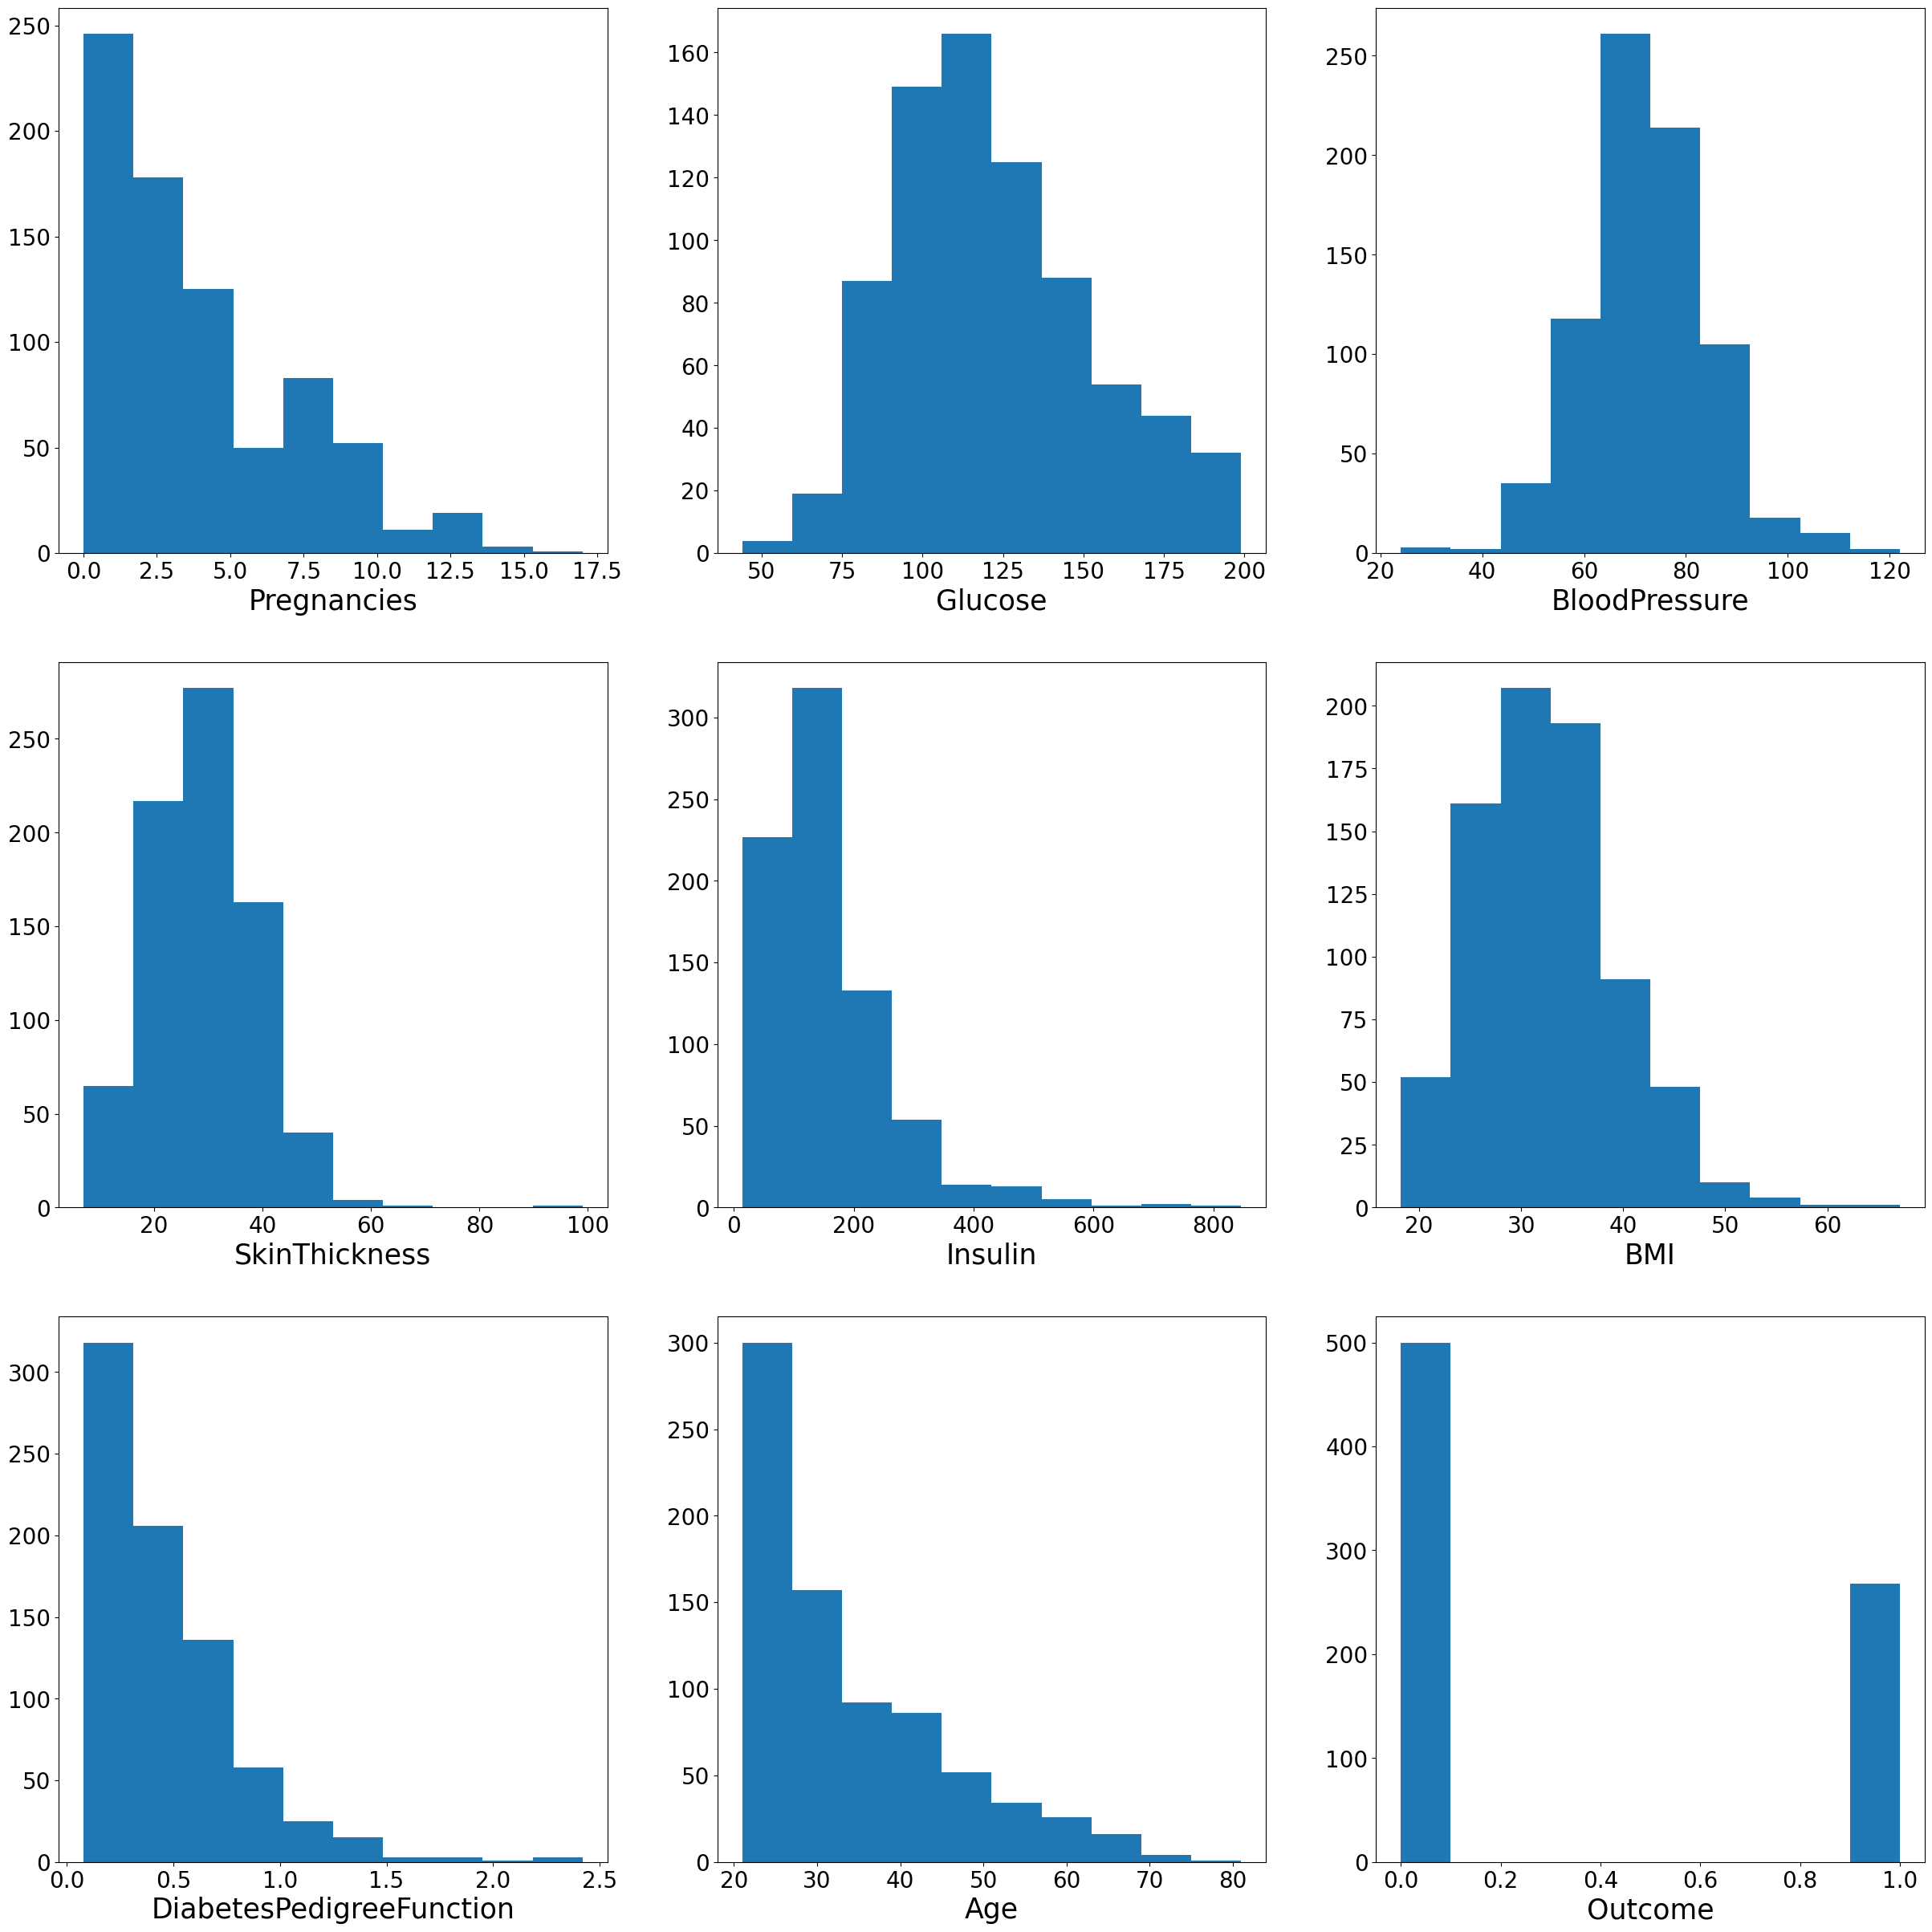

In [11]:
columns = [_ for _ in data.columns]
plt.figure(figsize=(30, 30))
parameters = {'xtick.labelsize': 20, 'ytick.labelsize': 20, 'axes.labelsize':25} #設定 x 和 y 標籤及座標刻度字型大小
plt.rcParams.update(parameters)

for index, column in enumerate(columns):
    plt.subplot(3, 3, index+1)
    plt.hist(data[column])
    plt.xlabel(column)
    
plt.show()

### 觀察兩變數之間的相關性
    處理完缺失值問題後，重新觀察每個變數與 Outcome 之間的關係（下圖中最後一欄），雖然每個變數和 Outcome 之間的相關性都沒有很高，但也沒有一個變數相關性特別低，因此在這裡不特別刪除某個變數

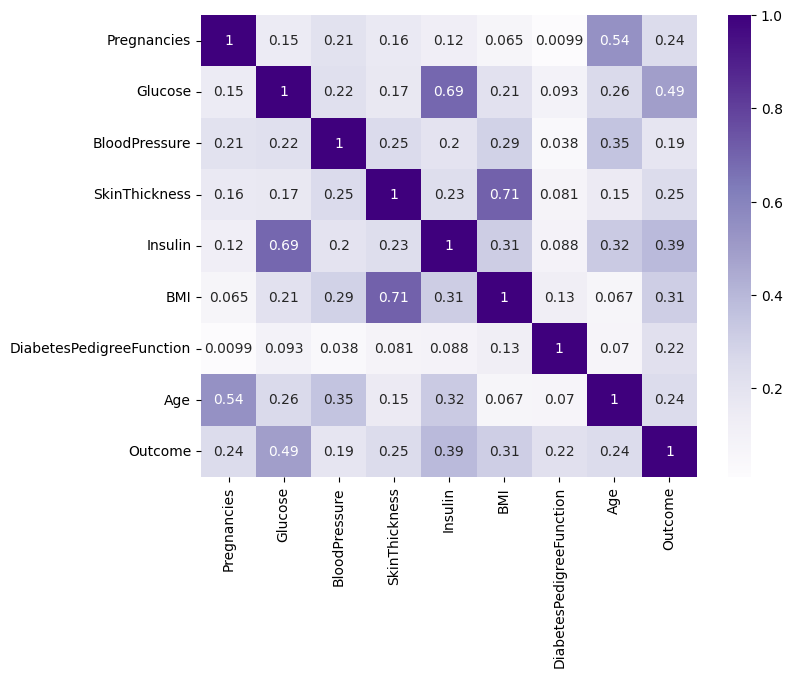

In [32]:
corr = data.corr()
plt.figure(figsize = (8,6))
sns.heatmap(corr, annot=True, cmap='Purples')

parameters = {'xtick.labelsize': 1, 'ytick.labelsize': 1} 
plt.rcParams.update(parameters)
plt.show()

### 查看數據基本統計資訊

In [25]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,725.000000,725.000000,725.000000,725.000000,725.000000,725.000000,725.000000,725.000000,725.000000
mean,3.893793,119.808276,72.208276,28.541269,144.489876,32.190345,0.444668,33.118621,0.336552
std,3.368858,29.281647,11.652991,9.152347,75.726865,6.543122,0.272375,11.563290,0.472856
min,0.000000,44.000000,24.000000,7.000000,15.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,22.000000,86.990000,27.500000,0.239000,24.000000,0.000000
50%,3.000000,115.000000,72.000000,28.410000,131.740000,32.300000,0.362000,29.000000,0.000000
75%,6.000000,137.000000,80.000000,35.000000,185.000000,36.200000,0.600000,40.000000,1.000000
max,17.000000,198.000000,110.000000,60.000000,402.000000,53.200000,1.390000,81.000000,1.000000


### 透過 boxplot 來查看各個特徵在資料中的分布狀況

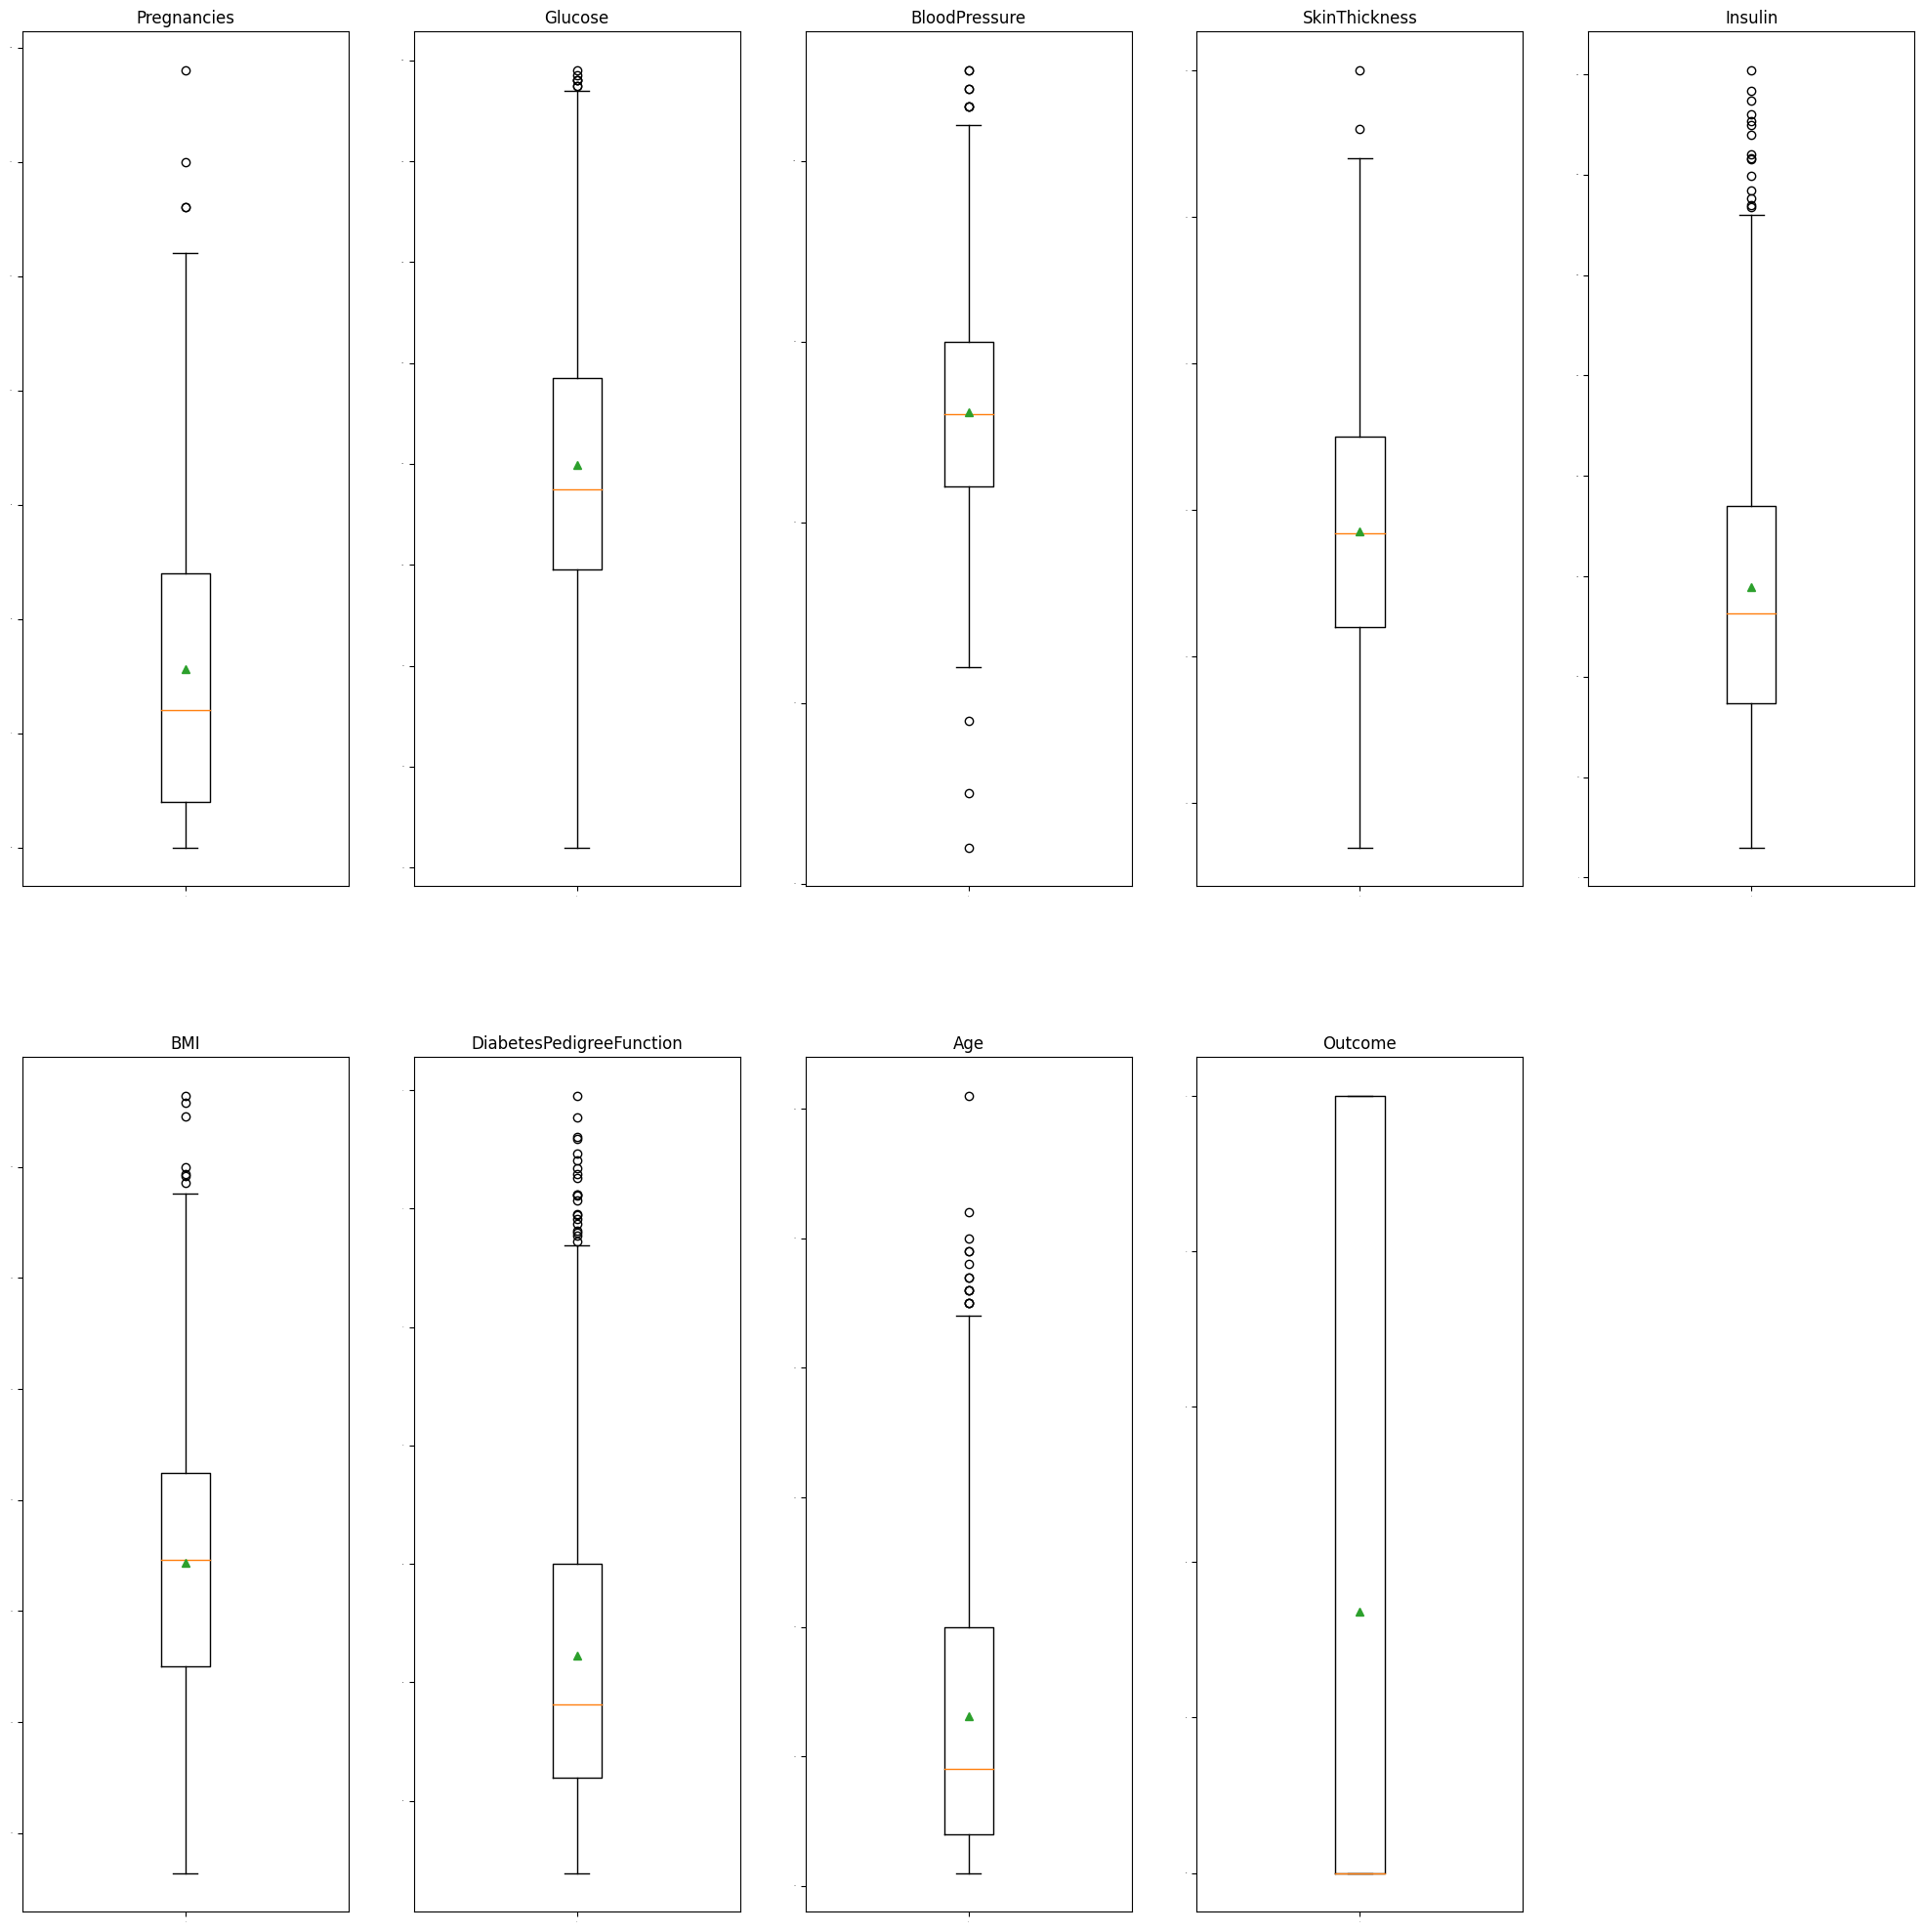

In [35]:
columns = [_ for _ in data.columns]
plt.figure(figsize=(25, 25))

for index, column in enumerate(columns):
    plt.subplot(2, 5, index+1)
    plt.boxplot(data[column],showmeans=True)
    plt.title(column)
    
plt.show()

1.發現數據中存在一些離群值，這些離群值可能超出了人體正常範圍。雖然在疾病預測中存在一定程度的異常值是正常的，但是由於數據集較小，決定刪除這些極端異常值。

2.極端異常點：上界Q3+3(Q3-Q1) 下界Q1-3(Q3-Q1)

In [15]:
def remove_outliers(feature, data):
    first_quartile = data[feature].describe()['25%']
    third_quartile = data[feature].describe()['75%']
    IQR = third_quartile - first_quartile

    index = data[(data[feature] < (first_quartile - 3*IQR)) | (data[feature] > (first_quartile + 3*IQR))].index
    data = data.drop(index)
    return data

In [16]:
outlier_features = ['Insulin', 'Glucose', 'BloodPressure', 'SkinThickness', 'BMI', 'DiabetesPedigreeFunction']
for feat in outlier_features:
    data = remove_outliers(feat,data)

In [36]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,725.000000,725.000000,725.000000,725.000000,725.000000,725.000000,725.000000,725.000000,725.000000
mean,3.893793,119.808276,72.208276,28.541269,144.489876,32.190345,0.444668,33.118621,0.336552
std,3.368858,29.281647,11.652991,9.152347,75.726865,6.543122,0.272375,11.563290,0.472856
min,0.000000,44.000000,24.000000,7.000000,15.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,22.000000,86.990000,27.500000,0.239000,24.000000,0.000000
50%,3.000000,115.000000,72.000000,28.410000,131.740000,32.300000,0.362000,29.000000,0.000000
75%,6.000000,137.000000,80.000000,35.000000,185.000000,36.200000,0.600000,40.000000,1.000000
max,17.000000,198.000000,110.000000,60.000000,402.000000,53.200000,1.390000,81.000000,1.000000


## 特徵工程

In [18]:
x_features = data.iloc[:, :-1]
y_label = data.iloc[:, -1]
print(x_features)
print("---------------------------------------------------------------------------------------------------------")
print(y_label)

     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  DiabetesPedigreeFunction  Age
0              6    148.0           72.0          35.00   196.35  33.6                     0.627   50
1              1     85.0           66.0          29.00    56.37  26.6                     0.351   31
2              8    183.0           64.0          17.75   251.37  23.3                     0.672   32
3              1     89.0           66.0          23.00    94.00  28.1                     0.167   21
5              5    116.0           74.0          25.05   115.78  25.6                     0.201   30
6              3     78.0           50.0          32.00    88.00  31.0                     0.248   26
7             10    115.0           72.0          34.37   172.64  35.3                     0.134   29
9              8    125.0           96.0          29.46   217.39  32.3                     0.232   54
10             4    110.0           92.0          40.79   145.34  37.6            

In [19]:
#! pip install scikit-learn

In [20]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

### 模型參數選擇
    使用 GridSearchCV 函數做 Cross Validation，統計 accuracy 的平均數/標準差，找出最佳參數組合

In [21]:
c_values = list(np.arange(1, 10))

param_grid = [ {'C': c_values, 'penalty': ['l1'], 'solver' : ['liblinear']},
              {'C': c_values, 'penalty': ['l2'], 'solver' : ['liblinear', 'newton-cg', 'lbfgs']} ]

grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='accuracy')
grid.fit(x_features, y_label)

print(grid.best_params_) 
print(grid.best_estimator_)

{'C': 7, 'penalty': 'l2', 'solver': 'newton-cg'}
LogisticRegression(C=7, max_iter=1000, solver='newton-cg')


### 執行 K-fold validation進行驗證

In [22]:
# 由於此任務是希望預測患者是否具有糖尿病，屬於二分類任務，因此選擇此離散型模型
model = LogisticRegression(C=8, max_iter=1000, multi_class='ovr', penalty='l1', solver='liblinear') 
kf = KFold(n_splits=5, shuffle=True, random_state=42)

val_bias = []
val_variance = []
train_errors = []
val_errors = []

for train_index, val_index in kf.split(x_features):
    
    #拆分成訓練集和測試集
    x_train, y_train = x_features.iloc[train_index], y_label.iloc[train_index]
    x_val, y_val = x_features.iloc[val_index], y_label.iloc[val_index]
    
    #訓練模型
    model.fit(x_train, y_train)
    
    y_train_pred = model.predict(x_train) #預測訓練集資料
    y_val_pred = model.predict(x_val) #預測測試集資料
    
    #計算 Bias 和 Variance
    bias = np.mean((y_val_pred - np.mean(y_val) ** 2))
    variance = np.var(y_val_pred)
    
    # 計算訓練和測試的誤差
    val_bias.append(bias)
    val_variance.append(variance)
                   
    train_error = np.sum((y_train_pred - y_train) ** 2) / len(y_train_pred)
    val_error = np.sum((y_val_pred - y_val) ** 2) / len(y_val_pred)
    
    train_errors.append(train_error)
    val_errors.append(val_error)

# 輸出 Bias and variance
print(f"Bias : {val_bias}")
print(f"Variance : {val_variance}")

#輸出平均訓練和測試誤差
print(f"平均訓練誤差：{sum(train_errors) / len(train_errors)}")
print(f"平均測試誤差：{sum(val_errors) / len(val_errors)}") 

Bias : [0.1590487514863258, 0.11800237812128417, 0.18506539833531507, 0.11966706302021407, 0.1866349583828775]
Variance : [0.20280618311533888, 0.17579072532699166, 0.1966230677764566, 0.18663495838287747, 0.2140309155766944]
平均訓練誤差：0.21517241379310342
平均測試誤差：0.21793103448275866


## 總結

1.直接刪除缺失值的方法，透過模型預測結果，平均訓練誤差和平均測試誤差都大概落在1.6，可能由於缺失值比較多，所以反而填充方法的效果比直接刪除的效果是要更差的，或許有其他更適合的填充方法，還需要再多嘗試實驗。但我認為直接刪除缺失值的方法，會一定程度影響模型評估結果的可信度。因此，在作業中，還是選擇採用填充的方式處理缺失值。

2.離群值得處理還有很多的方式，但由於這次處理數據的離群值個數較少，因此選擇直接刪除的方式處理缺失值。

3.由長條圖可觀察出很多變數都存在右偏的現象，在所學的很多機器學習演算法的理論前提都是建立在數據是常態分佈的，因此，我認為在資料前處理的部分，應該還要對這些具有右偏現象的變數進行處理，或許模型會有更佳的預測結果。